In [1]:
from numpy import load
import numpy as np
import os
import random
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from keras import metrics
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import logging
import platform

# ensure reproducibility.
seed=9397
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

2023-01-02 23:59:29.969271: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-02 23:59:30.103242: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-02 23:59:30.584644: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64
2023-01-02 23:59:30.584701: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: can

In [2]:
# for logging
# let's try to move away from print
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
# limiting gpu memory, to allow bigger batch size
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        logger.info("%s Physical GPUs, %s Logical GPUs", len(gpus), len(logical_gpus))

    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        logger.error('You got error = > %s', e)
        logger.warning('Something is wrong with the configuration !')

INFO:__main__:1 Physical GPUs, 1 Logical GPUs
2023-01-02 23:59:32.012817: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-02 23:59:32.482898: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10180 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


In [4]:
# load dict of arrays dataset
X_train = load('X_train.npy')
Y_train = load('Y_train.npy')

logger.info(" Done loading data array !")

X_train.shape,Y_train.shape
logger.info("%s Training array size, %s Training label array size", X_train.shape, Y_train.shape)

INFO:__main__: Done loading data array !
INFO:__main__:(56962, 256, 256) Training array size, (56962,) Training label array size


In [5]:
# check shape
X_train = np.expand_dims(X_train,-1)
logger.info(" check training array shape, %s ", X_train.shape)

INFO:__main__: check training array shape, (56962, 256, 256, 1) 


In [6]:
def tf_pfbeta(from_logits=True, beta=1.0, epsilon=1e-07):
    
    def pfbeta(y_true, y_pred):
        y_pred = tf.cond(
            tf.cast(from_logits, dtype=tf.bool),
            lambda: tf.nn.sigmoid(y_pred),
            lambda: y_pred,
        )
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        ctp = tf.reduce_sum(y_true * y_pred, axis=-1)
        cfp = tf.reduce_sum(y_pred, axis=-1) - ctp

        c_precision = ctp / (ctp + cfp)
        c_recall = ctp / tf.reduce_sum(y_true)
        
        def compute_fractions():
            numerator = c_precision * c_recall
            denominator = beta**2 * c_precision + c_recall
            return (1 + beta**2) * tf.math.divide_no_nan(numerator, denominator)
        
        return tf.cond(
            tf.logical_and(
                tf.greater(c_precision, 0.), tf.greater(c_recall, 0.)
            ),
            compute_fractions,
            lambda: tf.constant(0, dtype=tf.float32)
        )
    
    return pfbeta

def tf_auc(from_logits=True):
    auc_fn = metrics.AUC()
    
    def auc(y_true, y_pred):
        y_pred = tf.cond(
            tf.cast(from_logits, dtype=tf.bool),
            lambda: tf.nn.sigmoid(y_pred),
            lambda: y_pred,
        )
        return auc_fn(y_true, y_pred)
    
    return auc


def weighted_binary_loss(weight, from_logits=True, reduction="mean"):
    def inverse_sigmoid(sigmoidal):
        return - tf.math.log(1. / sigmoidal - 1.)

    def weighted_loss(labels, predictions):
        predictions = tf.convert_to_tensor(predictions)
        labels = tf.cast(labels, predictions.dtype)
        num_samples = tf.cast(tf.shape(labels)[-1], dtype=labels.dtype)

        logits = tf.cond(
            tf.cast(from_logits, dtype=tf.bool),
            lambda: predictions,
            lambda: inverse_sigmoid(sigmoidal=predictions),
        )
        loss = tf.nn.weighted_cross_entropy_with_logits(
            tf.cast(labels, dtype=tf.float32), logits, pos_weight=weight
        )
        
        if reduction.lower() == "mean":
            return tf.reduce_mean(loss)
        elif reduction.lower() == "sum":
            return tf.reduce_sum(loss) / num_samples
        elif reduction.lower() == "none":
            return loss
        else:
            raise ValueError(
                'Reduction type is should be `mean` or `sum` or `none`. ',
                f'But, received {reduction}'
            )
    return weighted_loss

def binary_focal_loss(
    alpha=0.25, 
    gamma=2.0, 
    label_smoothing=0, 
    from_logits=False,
    apply_class_balancing=False,
    apply_positive_weight=1,
    reduction="mean"
):
    '''
    alpha: A weight balancing factor for class 1, default is 0.25. 
        The weight for class 0 is 1.0 - alpha.
    
    gamma: A focusing parameter used to compute the focal factor, default is 2.0
    
    apply_class_balancing: A bool, whether to apply weight balancing on the binary 
        classes 0 and 1.
    '''
    
    def smooth_labels(labels):
        return labels * (1.0 - label_smoothing) + 0.5 * label_smoothing
    
    def compute_loss(labels, logits):
        logits = tf.convert_to_tensor(logits)
        labels = tf.cast(labels, logits.dtype)
        labels = tf.cond(
            tf.cast(label_smoothing, dtype=tf.bool),
            lambda: smooth_labels(labels),
            lambda: labels,
        )
        num_samples = tf.cast(tf.shape(labels)[-1], dtype=labels.dtype)
        cross_entropy = weighted_binary_loss(
            apply_positive_weight, from_logits, reduction='none'
        )(labels, logits)
        
        sigmoidal = tf.cond(
            tf.cast(from_logits, dtype=tf.bool),
            lambda: tf.nn.sigmoid(logits),
            lambda: logits,
        )
        pt = labels * sigmoidal + (1.0 - labels) * (1.0 - sigmoidal)
        focal_factor = tf.pow(1.0 - pt, gamma)
        focal_bce =  focal_factor * cross_entropy
        
        if apply_class_balancing:
            weight = labels * alpha + (1 - labels) * (1 - alpha)
            focal_bce = weight * focal_bce

        if reduction == 'mean':
            return tf.reduce_mean(focal_bce)
        elif reduction == 'sum':
            return tf.reduce_sum(focal_bce) / num_samples
        else:
            raise ValueError(
                'Reduction type should be `mean` or `sum` ',
                f'But, received {reduction}'
            )
    return compute_loss

In [7]:
def cnn_model():
    model = Sequential()
    input_shape = (256, 256, 1)

    model.add(Conv2D(filters=32, kernel_size = (3,3), strides =1, padding = 'same', activation = 'relu', input_shape = input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size = (3,3), strides =1, padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size = (3,3), strides =1, padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=256, kernel_size = (3,3), strides =1, padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.13))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.13))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(50, activation = 'relu'))
    model.add(Dense(1 , activation="sigmoid"))
    
    model.compile(loss='binary_crossentropy',
              
            optimizer=Adam(lr=0.001),metrics = [
            tf_pfbeta(beta=1.0, from_logits=True),
            tf_auc(from_logits=True)
        ])
    
    return model

In [8]:
# split dataset
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.35, random_state=42)
logger.info("y_train data type, %s ", y_train.dtype)

INFO:__main__:y_train data type, int64 


In [9]:
# to get your running OS
my_os = platform.system()

# Initilize Distributed Training
if my_os == 'Windows':
    # use this strategy because NCCL is not availbale in windows
    mirrored_strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

elif my_os =='Linux':
    mirrored_strategy = tf.distribute.MirroredStrategy()
    # mirrored_strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
    logger.info('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))

else:
    logger.warning("Eh, ko pakai android ?")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:__main__:Number of devices: 1


In [10]:
# set batch size for training
EPOCHS = 100
BATCH_SIZE_PER_REPLICA = 16  # you may change to make training faster (if memory is available)
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * mirrored_strategy.num_replicas_in_sync
logger.info("BATCH_SIZE is %s ", BATCH_SIZE)

sabar = 25
# Available metrics are: loss,pfbeta,auc,val_loss,val_pfbeta,val_auc
# dict_keys(['loss', 'pfbeta', 'auc', 'val_loss', 'val_pfbeta', 'val_auc'])
earlystop_callback = keras.callbacks.EarlyStopping( monitor='val_auc', mode='auto',
                            verbose=1, patience=sabar, min_delta=1,
                            baseline=0.1)

filepath="model/tetek-weights-improvement-{epoch:02d}-{val_auc:.2f}.hdf5"

checkpoint_callback = ModelCheckpoint(filepath, monitor="val_auc", mode="min",
	save_best_only=True, verbose=1)

INFO:__main__:BATCH_SIZE is 16 


In [11]:
with mirrored_strategy.scope():
    logger.info("Mirror strategy is used !")
    
    model = cnn_model()
    logger.info(model.summary())

INFO:__main__:Mirror strategy is used !


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


/home/twistcode/Downloads/guasukalu/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0

INFO:__main__:None


In [12]:
start = time.time()

In [13]:
%time history = model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[earlystop_callback, checkpoint_callback],epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/100


2023-01-02 23:59:46.829871: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


2315/2315 [==============================] - ETA: 0s - loss: 0.7952 - pfbeta: 0.0673 - auc: 0.4772
Epoch 1: val_auc improved from inf to 0.50871, saving model to model/tetek-weights-improvement-01-0.51.hdf5
2315/2315 [==============================] - 80s 33ms/step - loss: 0.7952 - pfbeta: 0.0673 - auc: 0.4772 - val_loss: 0.1678 - val_pfbeta: 0.0667 - val_auc: 0.5087
Epoch 2/100
2313/2315 [============================>.] - ETA: 0s - loss: 0.1735 - pfbeta: 0.0677 - auc: 0.5223
Epoch 2: val_auc did not improve from 0.50871
2315/2315 [==============================] - 70s 30ms/step - loss: 0.1734 - pfbeta: 0.0676 - auc: 0.5223 - val_loss: 0.1721 - val_pfbeta: 0.0666 - val_auc: 0.5214
Epoch 3/100
2314/2315 [============================>.] - ETA: 0s - loss: 0.1721 - pfbeta: 0.0673 - auc: 0.5231
Epoch 3: val_auc did not improve from 0.50871
2315/2315 [==============================] - 70s 30ms/step - loss: 0.1721 - pfbeta: 0.0673 - auc: 0.5231 - val_loss: 0.1771 - val_pfbeta: 0.0665 - val_au

In [14]:
logger.info("It took {} seconds to train".format(time.time() - start)) 
logger.info("Training finish !")

INFO:__main__:It took 1782.907841205597 seconds to train
INFO:__main__:Training finish !


In [15]:
logger.info("TF history have these metrics -->, %s ", history.history.keys())

INFO:__main__:TF history have these metrics -->, dict_keys(['loss', 'pfbeta', 'auc', 'val_loss', 'val_pfbeta', 'val_auc']) 


In [16]:
# save model
model.save('model/rsna_hoi_tetek.h5')
print('Model Saved!')

Model Saved!


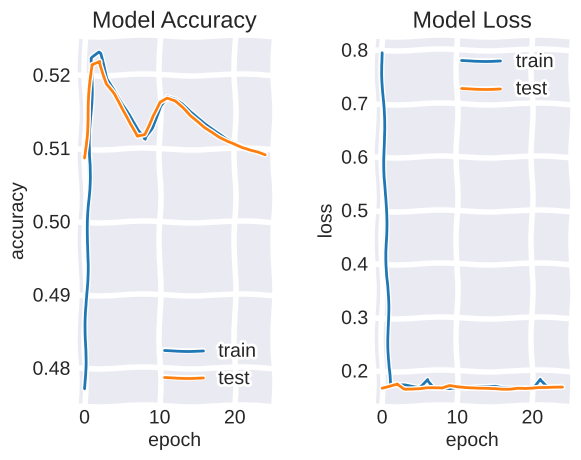

In [17]:
plt.xkcd()
# plt.style.use("seaborn")
plt.style.use("seaborn-v0_8-darkgrid")

# summarize history for loss
# Model accuracy
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])

# Model Losss
plt.subplot(1, 2, 2) # index 2
plt.subplots_adjust(wspace=0.5)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.savefig('model/training_plot_many_data.png')
plt.show()

In [20]:
# model.evaluate(x_test,y_test)